<a href="https://colab.research.google.com/github/TomasWeinstabl/DataScience3/blob/main/NLP_Completo_Tomas_Weinstabl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! python -m spacy download es_core_news_md
! pip install -U symspellpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 18.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.1/144.1 kB 9.6 MB/s eta 0:00:00


In [ ]:
import nltk # importar natural language toolkit
nltk.download('punkt')
nltk.download('stopwords') # modulo para descargar stopwords en diferentes idiomas
nltk.download('wordnet')
from nltk.corpus import stopwords
import pandas as pd
import numpy  as np
import re
import string
import plotly
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
import time
import spacy
import es_core_news_md
from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.probability import FreqDist
from wordcloud import WordCloud
import pickle
from symspellpy import SymSpell
import pkg_resources
from symspellpy import SymSpell, Verbosity

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
<ipython-input-3-f80a7cb5fd39>:23: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [ ]:
import es_core_news_md
nlp = es_core_news_md.load()

In [ ]:
!wget https://mcauleylab.ucsd.edu/public_datasets/data/amazon_2023/raw/review_categories/Video_Games.jsonl.gz

--2025-03-30 11:15:00--  https://mcauleylab.ucsd.edu/public_datasets/data/amazon_2023/raw/review_categories/Video_Games.jsonl.gz
Resolving mcauleylab.ucsd.edu (mcauleylab.ucsd.edu)... 169.228.63.88
Connecting to mcauleylab.ucsd.edu (mcauleylab.ucsd.edu)|169.228.63.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 814206092 (776M) [application/gzip]
Saving to: ‘Video_Games.jsonl.gz.1’

Video_Games.jsonl.g 100%[===================>] 776.49M  2.31MB/s    in 39s     

2025-03-30 11:15:39 (20.0 MB/s) - ‘Video_Games.jsonl.gz.1’ saved [814206092/814206092]



In [ ]:
# Leer el archivo en partes
amazon_reviews_iter = pd.read_json(
    '/content/Video_Games.jsonl.gz',
    lines=True,
    compression='gzip',
    chunksize=10000
)
# Procesar un solo chunk como ejemplo
for chunk in amazon_reviews_iter:
    data = chunk
    print(data.head(10))  # Muestra las primeras filas del chunk
    break  # Detén después del primer chunk si solo quieres una parte
# Seleccionando solo los primeros 10,000 registros para calculo mas rapido
#amazon_reviews = amazon_reviews[:10000]

   rating                                              title  \
0       4                     It’s pretty sexual. Not my fav   
1       5                                   Good. A bit slow   
2       5  ... an order for my kids & they have really en...   
3       5                        Great alt to pro controller   
4       5                                      solid product   
5       3  love all the amazing colors but the black is r...   
6       5                                     Will use again   
7       5  if its prime day and you're contemplating, jus...   
8       5                     Price bumps it up from 4 stars   
9       1                            It's an Auto-renew scam   

                                                text  \
0  I’m playing on ps5 and it’s interesting.  It’s...   
1  Nostalgic fun.  A bit slow.  I hope they don’t...   
2  This was an order for my kids & they have real...   
3  These work great, They use batteries which is ...   
4  I would reco

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   rating             10000 non-null  int64         
 1   title              10000 non-null  object        
 2   text               10000 non-null  object        
 3   images             10000 non-null  object        
 4   asin               10000 non-null  object        
 5   parent_asin        10000 non-null  object        
 6   user_id            10000 non-null  object        
 7   timestamp          10000 non-null  datetime64[ns]
 8   helpful_vote       10000 non-null  int64         
 9   verified_purchase  10000 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(2), object(6)
memory usage: 713.0+ KB


In [ ]:
# Diccionario con los nombres antiguos y los nuevos
names = {
    'asin': 'ProductId',
    'rating': 'Score',
    'helpful_vote': 'HelpfulnessNumerator',
    'timestamp': 'Time',
    'text': 'Text',
    'reviewerName': 'UserId',
    'title': 'Summary'
}

# Renombrar las columnas del DataFrame
data.rename(columns=names, inplace=True)

In [ ]:
data

,Score,Summary,Text,images,ProductId,parent_asin,user_id,Time,HelpfulnessNumerator,verified_purchase
0,4,It’s pretty sexual. Not my fav,I’m playing on ps5 and it’s interesting. It’s...,[],B07DJWBYKP,B07DK1H3H5,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,2020-12-17 06:33:24.795,0,True
1,5,Good. A bit slow,Nostalgic fun. A bit slow. I hope they don’t...,[],B00ZS80PC2,B07SRWRH5D,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,2020-04-16 15:31:54.941,1,False
2,5,... an order for my kids & they have really en...,This was an order for my kids & they have real...,[],B01FEHJYUU,B07MFMFW34,AGXVBIUFLFGMVLATYXHJYL4A5Q7Q,2017-03-30 12:37:11.000,0,True
3,5,Great alt to pro controller,"These work great, They use batteries which is ...",[],B07GXJHRVK,B0BCHWZX95,AFTC6ZR5IKNRDG5JCPVNVMU3XV2Q,2019-12-29 16:40:34.017,0,True
4,5,solid product,I would recommend to anyone looking to add jus...,[],B00HUWA45W,B00HUWA45W,AFTC6ZR5IKNRDG5JCPVNVMU3XV2Q,2015-03-29 01:18:52.000,0,True
...,...,...,...,...,...,...,...,...,...,...
9995,3,Fun,"Works well, and is very fun to play! I have no...",[],B00ZQB7LZU,B00VG3PUFA,AEMYQLW2XHEIIGEHOC37XLYGFO4Q,2018-09-13 13:00:27.630,0,True
9996,5,"Works, seller was amazing!",Ordered to replace the cord on PlayStation 4. ...,[],B00HUXPZPK,B0BDWVBWC9,AH65TAHPBWFT2FXGOVL7EIJTRULQ,2022-02-25 20:27:23.135,0,True
9997,5,Don’t even like Star Wars.,Not even a Star Wars fan…still really good game.,[],B07QQGJHD3,B07QQTJMRF,AESRJGBQLMK4HZYP53GXIUQ47GYQ,2021-08-22 02:13:50.441,1,True
9998,2,Boo!,Booooo!,[],B0773RCY75,B07NVTR5FD,AESRJGBQLMK4HZYP53GXIUQ47GYQ,2021-08-22 02:13:03.833,0,True


In [ ]:
amazon_reviews = data

In [ ]:
amazon_reviews.Score.value_counts()

,count
Score,
5,6501
4,1573
3,742
1,740
2,444


In [ ]:
percent_val = 100 * amazon_reviews.Score.value_counts()/amazon_reviews.shape[0]
percent_val

,count
Score,
5,65.01
4,15.73
3,7.42
1,7.40
2,4.44


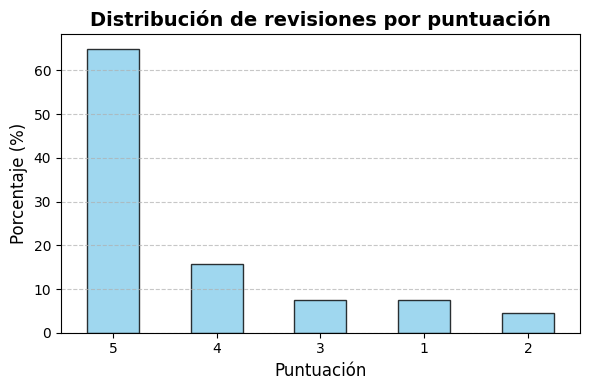

In [ ]:
# Crear el gráfico de barras
plt.figure(figsize=(6, 4))  # Ajusta el tamaño del gráfico
percent_val.plot.bar(color='skyblue', edgecolor='black', alpha=0.8)

# Añadir título y etiquetas con tamaños optimizados
plt.title('Distribución de revisiones por puntuación', fontsize=14, fontweight='bold')
plt.xlabel('Puntuación', fontsize=12)
plt.ylabel('Porcentaje (%)', fontsize=12)

# Personalizar las etiquetas del eje x
plt.xticks(rotation=0, fontsize=10)

# Añadir cuadrícula para mejorar la legibilidad
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajustar márgenes
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [ ]:
amazon_reviews['Text']

,Text
0,I’m playing on ps5 and it’s interesting. It’s...
1,Nostalgic fun. A bit slow. I hope they don’t...
2,This was an order for my kids & they have real...
3,"These work great, They use batteries which is ..."
4,I would recommend to anyone looking to add jus...
...,...
9995,"Works well, and is very fun to play! I have no..."
9996,Ordered to replace the cord on PlayStation 4. ...
9997,Not even a Star Wars fan…still really good game.
9998,Booooo!


In [ ]:
amazon_reviews.head(10)

,Score,Summary,Text,images,ProductId,parent_asin,user_id,Time,HelpfulnessNumerator,verified_purchase
0,4,It’s pretty sexual. Not my fav,I’m playing on ps5 and it’s interesting. It’s...,[],B07DJWBYKP,B07DK1H3H5,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,2020-12-17 06:33:24.795,0,True
1,5,Good. A bit slow,Nostalgic fun. A bit slow. I hope they don’t...,[],B00ZS80PC2,B07SRWRH5D,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,2020-04-16 15:31:54.941,1,False
2,5,... an order for my kids & they have really en...,This was an order for my kids & they have real...,[],B01FEHJYUU,B07MFMFW34,AGXVBIUFLFGMVLATYXHJYL4A5Q7Q,2017-03-30 12:37:11.000,0,True
3,5,Great alt to pro controller,"These work great, They use batteries which is ...",[],B07GXJHRVK,B0BCHWZX95,AFTC6ZR5IKNRDG5JCPVNVMU3XV2Q,2019-12-29 16:40:34.017,0,True
4,5,solid product,I would recommend to anyone looking to add jus...,[],B00HUWA45W,B00HUWA45W,AFTC6ZR5IKNRDG5JCPVNVMU3XV2Q,2015-03-29 01:18:52.000,0,True
5,3,love all the amazing colors but the black is r...,love all the amazing colors but the black is r...,[],B016Y2BVKA,B073SC6V1D,AHXSBZT52TCPZUBVCBRICTHWUCBA,2018-02-08 21:15:39.574,0,True
6,5,Will use again,Instant delivery!,[],B004RMK57U,B004RMK57U,AHZIJGKEWRTAEOZ673G5B3SNXEGQ,2020-10-17 12:28:29.361,0,True
7,5,"if its prime day and you're contemplating, jus...",you should probably get these. you'll journal ...,[{'small_image_url': 'https://images-na.ssl-im...,B07N85FY1G,B0BYVN9ZK2,AFO6QN6ICKWUFQV3UEWK5EECIQTQ,2020-10-14 23:35:12.453,0,False
8,5,Price bumps it up from 4 stars,*it fits TWO wired Retro-bit 6 button controll...,[],B08L6782X9,B08L6782X9,AG6BAEKWLCWH2TW3KKLVK773YF6A,2021-05-19 18:24:30.253,0,True
9,1,It's an Auto-renew scam,Sony and Amazon are collaborating in an Auto-r...,[],B017V6YVDC,B017V6YVDC,AG6BAEKWLCWH2TW3KKLVK773YF6A,2020-12-12 00:54:34.794,2,True


Tamaño del texto concatenado: 4020488 caracteres


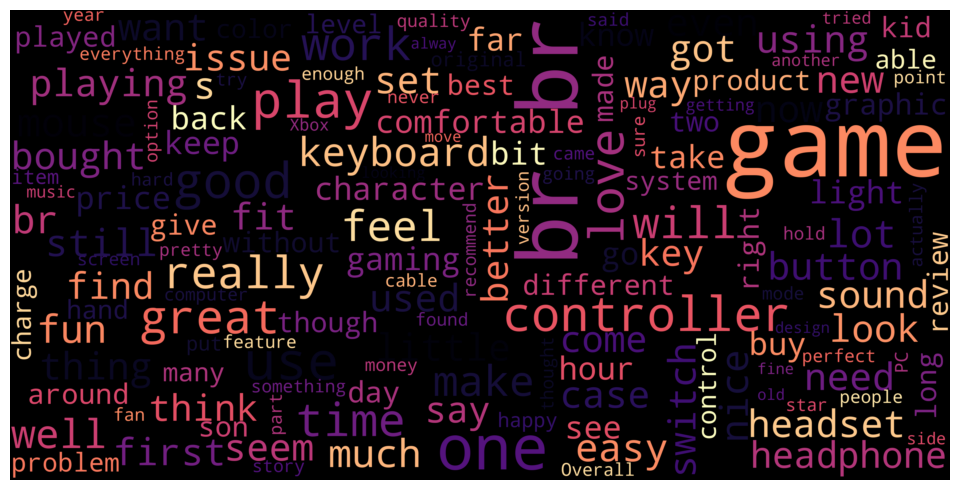

In [ ]:
# Concatenar el texto de todas las revisiones
word_cloud_text = ' '.join(amazon_reviews.Text.dropna())  # Manejo de valores nulos
print(f"Tamaño del texto concatenado: {len(word_cloud_text)} caracteres")

# Configuración del WordCloud
wordcloud = WordCloud(
    max_font_size=80,         # Tamaño máximo de la fuente ajustado
    max_words=150,            # Número máximo de palabras
    background_color="black", # Fondo blanco
    scale=5,                  # Escala ajustada para mejorar el rendimiento
    width=800,                # Ancho de la imagen
    height=400,               # Alto de la imagen
    colormap='magma'        # Colormap para colores más atractivos
).generate(word_cloud_text)

# Mostrar el WordCloud
plt.figure(figsize=(10, 5))  # Tamaño del gráfico optimizado
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Ocultar ejes
plt.tight_layout()  # Ajustar márgenes
plt.show()

In [ ]:
amazon_reviews['Sentiment_rating'] = np.where(amazon_reviews.Score > 3, 1, 0)
amazon_reviews['Sentiment_rating'].value_counts()

,count
Sentiment_rating,
1,8074
0,1926


In [ ]:
# removiendo neutrales
amazon_reviews = amazon_reviews[amazon_reviews.Score != 3]

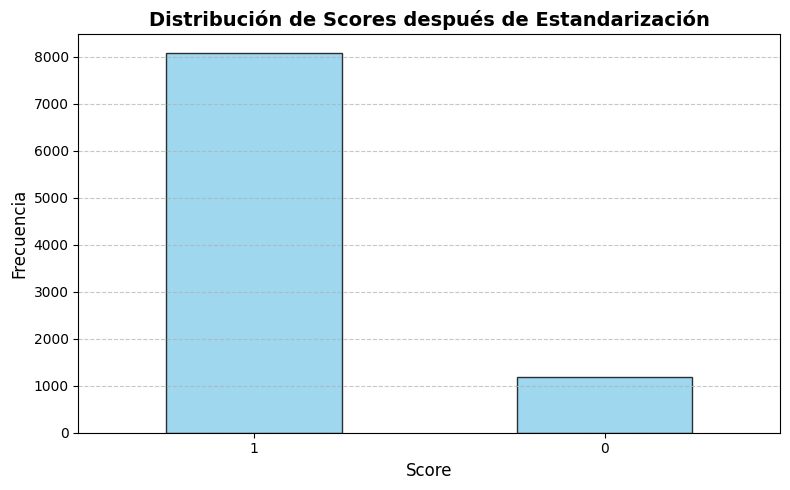

In [ ]:
# Configuración del tamaño de la figura
plt.figure(figsize=(8, 5))  # Ajusta el tamaño de la figura para mejor presentación

# Crear el gráfico de barras
amazon_reviews.Sentiment_rating.value_counts().plot.bar(
    color='skyblue',          # Color de las barras
    edgecolor='black',        # Color de los bordes de las barras
    alpha=0.8                 # Transparencia para un efecto más suave
)

# Añadir título y etiquetas
plt.title('Distribución de Scores después de Estandarización', fontsize=14, fontweight='bold')
plt.xlabel('Score', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)

# Personalización de las etiquetas del eje x
plt.xticks(rotation=0, fontsize=10)  # Asegurar que las etiquetas del eje X sean legibles

# Añadir cuadrícula en el eje Y para mejorar la legibilidad
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajustar márgenes y presentación
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [ ]:
amazon_reviews['reviews_text_new'] = amazon_reviews.Text.apply(lambda x: x.lower())

<ipython-input-128-5a39403d7401>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amazon_reviews['reviews_text_new'] = amazon_reviews.Text.apply(lambda x: x.lower())


In [ ]:
import nltk
from nltk.tokenize import word_tokenize

try:
    nltk.download('punkt')
    nltk.download('punkt_tab')
    nltk.download('averaged_perceptron_tagger')  # Para etiquetado POS si es necesario
except Exception as e:
    print(f"Error al descargar los recursos de nltk: {e}")

# Tokenizar los textos de amazon_reviews
try:
    token_lists = [word_tokenize(each) for each in amazon_reviews.Text]
    tokens = [item for sublist in token_lists for item in sublist]
    print("Numero de tokens unicos antes: ", len(set(tokens)))

    token_lists_lower = [word_tokenize(each) for each in amazon_reviews.reviews_text_new]
    tokens_lower = [item for sublist in token_lists_lower for item in sublist]
    print("Numero de tokens unicos nuevos: ", len(set(tokens_lower)))
except LookupError as e:
    print(f"Error de búsqueda de recursos NLTK: {e}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Numero de tokens unicos antes:  28953
Numero de tokens unicos nuevos:  24301


In [ ]:
# Seleccionando los caracteres no alfa numericos que no son espacios
special_chars = amazon_reviews.reviews_text_new.apply(lambda x: [each for each in list(x) if not each.isalnum() and each != ' '])

# obtener una lista de listas
flat_list = [item for sublist in special_chars for item in sublist]

# caracteres especiales unicos
print(set(flat_list))

{'️', "'", '%', '🌟', '\u200d', '😂', '*', '{', ';', '😀', '🎤', '#', '[', '🙂', '°', '😍', '🎂', '⚡', '🐻', '🐾', '😤', '💥', '🏻', '(', '-', '🥰', '\\', '🎥', '\xa0', '💘', '💕', '❤', '‘', '♀', '😑', '♂', '=', '’', '😊', '🎧', '🍀', '🤣', '+', '😔', '`', '💯', '.', '😻', '🏾', '“', '💎', '😒', '…', '😁', '🤭', '🤷', '😆', '☹', '🙋', '☀', '🎁', '😟', '🥳', '🤏', '�', '✅', '–', '🔴', ':', ',', '❣', '&', '_', '🙄', '⭐', '"', '😃', '🤔', '🤦', '👍', '>', '!', '@', '😞', '🤯', ')', '🏼', '📦', '💵', '<', '🔋', '©', '|', '/', '^', '👑', '”', '?', '🚚', '😚', '$', '•', '💜', '😉', '🙌', ']', '}', '✔', '😎', '🤩', '\u200b', '😅', '~', '—', '♥'}


In [ ]:
import re
review_backup = amazon_reviews.reviews_text_new.copy()
amazon_reviews.reviews_text_new = amazon_reviews.reviews_text_new.apply(
    lambda x: re.sub('[^A-Za-z0-9 ]+', ' ', x)
)

<ipython-input-131-fd4c087953c9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amazon_reviews.reviews_text_new = amazon_reviews.reviews_text_new.apply(


Probamos que efectivamente ambos arrays son iguales pero el nuevo no tiene caracteres especiales

amazon_reviews.text sería el texto inicial

review_backup sería el texto luego de la transformación a minúsculas

amazon_reviews.reviews_text_new sería review_backup pero con la transformación de quitar caracteres especiales

In [ ]:
review_backup.head(10)

,reviews_text_new
0,i’m playing on ps5 and it’s interesting. it’s...
1,nostalgic fun. a bit slow. i hope they don’t...
2,this was an order for my kids & they have real...
3,"these work great, they use batteries which is ..."
4,i would recommend to anyone looking to add jus...
6,instant delivery!
7,you should probably get these. you'll journal ...
8,*it fits two wired retro-bit 6 button controll...
9,sony and amazon are collaborating in an auto-r...
10,"good, a tad bit too bulky, but good. they stay..."


In [ ]:
amazon_reviews[['Text','reviews_text_new']].head(10)

,Text,reviews_text_new
0,I’m playing on ps5 and it’s interesting. It’s...,i m playing on ps5 and it s interesting it s...
1,Nostalgic fun. A bit slow. I hope they don’t...,nostalgic fun a bit slow i hope they don t...
2,This was an order for my kids & they have real...,this was an order for my kids they have real...
3,"These work great, They use batteries which is ...",these work great they use batteries which is ...
4,I would recommend to anyone looking to add jus...,i would recommend to anyone looking to add jus...
6,Instant delivery!,instant delivery
7,you should probably get these. you'll journal ...,you should probably get these you ll journal ...
8,*it fits TWO wired Retro-bit 6 button controll...,it fits two wired retro bit 6 button controll...
9,Sony and Amazon are collaborating in an Auto-r...,sony and amazon are collaborating in an auto r...
10,"good, a tad bit too bulky, but good. they stay...",good a tad bit too bulky but good they stay...


In [ ]:
#Comparamos el antes vs el después de la cantidad de tokens únicos tras aplicar las transformaciones (tanto la de minusculas como la de caracteres especiales)

token_lists = [word_tokenize(each) for each in amazon_reviews.Text]
tokens = [item for sublist in token_lists for item in sublist]
print("Numero de token unicos antes: ", len(set(tokens)))

token_lists = [word_tokenize(each) for each in amazon_reviews.reviews_text_new]
tokens = [item for sublist in token_lists for item in sublist]
print("Numero de tokens unicos despues: ", len(set(tokens)))

Numero de token unicos antes:  28953
Numero de tokens unicos despues:  19499


In [ ]:
#Accedemos al diccionario de stopwords de nltk en idioma inglés y metemos todas las stopwords en una lista llamada noise_words

nltk.download('stopwords')

noise_words = []
stopwords_corpus = nltk.corpus.stopwords
eng_stop_words = stopwords_corpus.words('english')
noise_words.extend(eng_stop_words)
print(len(noise_words))
noise_words

198


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 'her',
 'here',
 'hers',
 'herself',
 "he's",
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 'if',
 "i'll",
 "i'm",
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 "i've",
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [ ]:
#Obtenemos el top 1% de palabras en cantidad de apariciones

from collections import Counter

one_percentile = int(len(set(tokens)) * 0.01)
top_1_percentile = Counter(tokens).most_common(one_percentile)
top_1_percentile[:10]

[('the', 33798),
 ('i', 18856),
 ('and', 18725),
 ('to', 16812),
 ('a', 16557),
 ('it', 16495),
 ('br', 11957),
 ('is', 10949),
 ('of', 9813),
 ('this', 9721)]

In [ ]:
#Obtenemos el bottom 1% de palabras en cantidad de apariciones

bottom_1_percentile = Counter(tokens).most_common()[-one_percentile:]
bottom_1_percentile[:10]

[('replenishing', 1),
 ('unstuck', 1),
 ('openi', 1),
 ('ga', 1),
 ('pawn', 1),
 ('microscopic', 1),
 ('wack', 1),
 ('particles', 1),
 ('palmers', 1),
 ('loudest', 1)]

In [ ]:
#Añadimos el top 1% y el bottom 1% a la lista de noisewords, junto a las stopwords

noise_words.extend([word for word,val in top_1_percentile])
noise_words.extend([word for word,val in bottom_1_percentile])

In [ ]:
#Importamos librerías para stemming y lemmatization

from nltk.stem import PorterStemmer, WordNetLemmatizer, LancasterStemmer

nltk.download('wordnet')

from nltk.corpus import wordnet

porter = PorterStemmer()
lancaster = LancasterStemmer()
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
#Muestro los campos que nos serán útiles para el analisis de sentimiento

amazon_reviews[['Text','Score','Sentiment_rating']].head(10)

,Text,Score,Sentiment_rating
0,I’m playing on ps5 and it’s interesting. It’s...,4,1
1,Nostalgic fun. A bit slow. I hope they don’t...,5,1
2,This was an order for my kids & they have real...,5,1
3,"These work great, They use batteries which is ...",5,1
4,I would recommend to anyone looking to add jus...,5,1
6,Instant delivery!,5,1
7,you should probably get these. you'll journal ...,5,1
8,*it fits TWO wired Retro-bit 6 button controll...,5,1
9,Sony and Amazon are collaborating in an Auto-r...,1,0
10,"good, a tad bit too bulky, but good. they stay...",4,1


In [ ]:
# Creacion de metodo para stemming

from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

In [ ]:
# Creacion de un objeto tipo CountVectorizer

bow_counts = CountVectorizer(
    tokenizer=word_tokenize,
    stop_words=noise_words,
    ngram_range=(1, 1)
)

In [ ]:
# Preparamos el test split asignándole un 20% de los datos al set de testeo

from sklearn.model_selection import train_test_split

reviews_train, reviews_test = train_test_split(amazon_reviews, test_size=0.2, random_state=0)


In [ ]:
X_train_bow = bow_counts.fit_transform(reviews_train.reviews_text_new)
X_test_bow = bow_counts.transform(reviews_test.reviews_text_new)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'m", "'re", "'s", "'ve", 'might', 'must', "n't", 'sha', 'wo'] not in stop_words.
  warnings.warn(


In [ ]:
y_train_bow = reviews_train['Sentiment_rating']
y_test_bow = reviews_test['Sentiment_rating']

In [ ]:
# Obtenemos la cantidad de reseñas positivas y negativos dentro del set de test

y_test_bow.value_counts() / y_test_bow.shape[0]

,count
Sentiment_rating,
1,0.87203
0,0.12797


In [ ]:
# Comenzamos con el modelo de regresión logística

# Descargamos librería correspondientes para regresión logística
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# Entrenar el modelo
lr_model_all = LogisticRegression(C=1, solver="liblinear")
lr_model_all.fit(X_train_bow, y_train_bow)

# Predecir el output
test_pred_lr_prob = lr_model_all.predict_proba(X_test_bow)
test_pred_lr_all = lr_model_all.predict(X_test_bow)

print("F1 score: ", f1_score(y_test_bow, test_pred_lr_all))
print("Accuracy: ", accuracy_score(y_test_bow, test_pred_lr_all) * 100)

F1 score:  0.9411057692307693
Accuracy:  89.41684665226782


In [ ]:
# Averiguo las probabilidades de cada una de las predicciones

test_pred_lr_prob

array([[0.02626223, 0.97373777],
       [0.08376891, 0.91623109],
       [0.00134599, 0.99865401],
       ...,
       [0.04580419, 0.95419581],
       [0.02742596, 0.97257404],
       [0.00819207, 0.99180793]])

In [ ]:
# Me quedo sólo con las probabilidades que indican valor =1

probabilities = [each[1] for each in test_pred_lr_prob]

In [ ]:
#Armo un dataframe para almacenar los campos relevantes del test: texto, score, sentiment, predicción de sentimiento, y probabilidad de la misma

predictions = pd.DataFrame()
predictions['Text'] = reviews_test['Text']
predictions['Actual_Score'] = reviews_test['Score']
predictions['Sentiment_rating'] = reviews_test['Sentiment_rating']
predictions['Predicted_sentiment'] = test_pred_lr_all
predictions['Predicted_probability'] = probabilities

predictions.head(30)

,Text,Actual_Score,Sentiment_rating,Predicted_sentiment,Predicted_probability
3415,Works perfectly for the Xbox One controller. I...,4,1,1,0.973738
5461,Love the game play it all the time !,4,1,1,0.916231
33,I still own my Wii which works perfectly and I...,5,1,1,0.998654
6260,"Graphically, the game is good and the voice ac...",2,0,1,0.879818
4940,Gift,4,1,1,0.956437
648,Got this for my Switch as I didn't want to sav...,4,1,1,0.974098
8279,I have started EO II after I beat EO 1. I have...,5,1,1,0.857562
5347,The game looks to be okay but the case was des...,2,0,1,0.596849
4769,"Great quality just wrong game, my son wanted t...",4,1,1,0.890165
2981,I bought this controller as a replacement for ...,1,0,0,0.043805


In [ ]:
accuracy_score(predictions['Sentiment_rating'], predictions['Predicted_sentiment'])

0.8941684665226782

In [ ]:
predictions[
    predictions['Predicted_sentiment'] != predictions['Sentiment_rating']
].head(30)

,Text,Actual_Score,Sentiment_rating,Predicted_sentiment,Predicted_probability
6260,"Graphically, the game is good and the voice ac...",2,0,1,0.879818
5347,The game looks to be okay but the case was des...,2,0,1,0.596849
4038,Supposed to take around 4hrs to charge a batte...,4,1,0,0.002656
3968,Game too complicated to enjoy. Too many option...,2,0,1,0.998135
8829,I think this is a good face cushion which work...,4,1,0,0.044865
7632,"I won't repeat all that has been written, but ...",2,0,1,0.995060
1776,I've been using wireless keyboards and mouses ...,4,1,0,0.468344
3036,"Works sometimes, not terribly powerful, need p...",2,0,1,0.926615
1864,High quality look and feel with this controlle...,2,0,1,0.989243
4450,Ooo I got this new mouse and keyboard for my r...,5,1,0,0.328777


In [ ]:
# Suponiendo que 'predictions' es tu DataFrame con las predicciones
# (como se definió en tu código anterior)

# Filtrar las predicciones incorrectas
incorrect_predictions = predictions[predictions['Predicted_sentiment'] != predictions['Sentiment_rating']]

# Calcular las métricas para los falsos negativos (1 predicho como 0)
false_negatives = incorrect_predictions[incorrect_predictions['Sentiment_rating'] == 1]
total_false_negatives = len(false_negatives)
avg_prob_false_negatives = false_negatives['Predicted_probability'].mean()

# Calcular las métricas para los falsos positivos (0 predicho como 1)
false_positives = incorrect_predictions[incorrect_predictions['Sentiment_rating'] == 0]
total_false_positives = len(false_positives)
avg_prob_false_positives = false_positives['Predicted_probability'].mean()

# Crear la tabla
data = {
    'Tipo de error': ['Falsos Negativos (1 predicho como 0)', 'Falsos Positivos (0 predicho como 1)'],
    'Total': [total_false_negatives, total_false_positives],
    'Probabilidad promedio': [avg_prob_false_negatives, avg_prob_false_positives]
}

error_table = pd.DataFrame(data)

# Mostrar la tabla
print(error_table)

                          Tipo de error  Total  Probabilidad promedio
0  Falsos Negativos (1 predicho como 0)     49               0.245017
1  Falsos Positivos (0 predicho como 1)    147               0.837241


Tras hacer el modelo de regresión logística podemos concluir que la accuracy es aceptable, siendo esta del 89%.

También podemos decir que, sobre las predicciones erradas, la probabilidad de los falsos negativos promedia 0.24 (es decir, 0.24 alejado de una predicción contundentemente falsa de 0), mientras que los falsos positivos promedian 0.83 (es decir sólo 0.17 alejados de una predicción contundente positiva de 1).

Si bien haría falta otro analisis para demostrarlo, parecería ser que el hecho de que hayan tantos valores positivos en la muestra de prueba y tan pocos negativos, hace que las predicciones tengan un sesgo a predicir positivamente.

